# Balance LSMI Test Set Distribution

This notebook balances the LSMI test set to match the illuminant distribution of the training data. It ensures that:
1.  The distribution of illuminant clusters (Cool, Neutral, Warm, etc.) is uniform.
2.  Selected scenes have at least 2 illuminants.
3.  Balancing is performed by prioritizing scenes with "rarest" illuminant clusters.

It also visualizes the balanced dataset and sample scenes with ground truth illuminant locations.

In [36]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import rawpy
from tqdm import tqdm
from sklearn.cluster import KMeans

# Constants
LSMI_ROOT = "Data/LSMI/nikon"
META_FILE = os.path.join(LSMI_ROOT, "meta.json")
CLUSTER_CENTERS_FILE = "cluster_centers.npy"
OUTPUT_FILE = "lsmi_balanced.csv"

# Full Macbeth Color Checker Chart Coordinates (Source)
FULL_CELLCHART = np.float32([
    # Row 1
    [0.25, 0.25],   [2.75, 0.25],   [2.75, 2.75],   [0.25, 2.75],
    [3.00, 0.25],   [5.50, 0.25],   [5.50, 2.75],   [3.00, 2.75], 
    [5.75, 0.25],   [8.25, 0.25],   [8.25, 2.75],   [5.75, 2.75],
    [8.50, 0.25],   [11.00, 0.25],  [11.00, 2.75],  [8.50, 2.75],
    [11.25, 0.25],  [13.75, 0.25],  [13.75, 2.75],  [11.25, 2.75],
    [14.00, 0.25],  [16.50, 0.25],  [16.50, 2.75],  [14.00, 2.75],
    # Row 2  
    [0.25, 3.00],   [2.75, 3.00],   [2.75, 5.50],   [0.25, 5.50],
    [3.00, 3.00],   [5.50, 3.00],   [5.50, 5.50],   [3.00, 5.50],
    [5.75, 3.00],   [8.25, 3.00],   [8.25, 5.50],   [5.75, 5.50],
    [8.50, 3.00],   [11.00, 3.00],  [11.00, 5.50],  [8.50, 5.50],
    [11.25, 3.00],  [13.75, 3.00],  [13.75, 5.50],  [11.25, 5.50],
    [14.00, 3.00],  [16.50, 3.00],  [16.50, 5.50],  [14.00, 5.50],
    # Row 3
    [0.25, 5.75],   [2.75, 5.75],   [2.75, 8.25],   [0.25, 8.25],
    [3.00, 5.75],   [5.50, 5.75],   [5.50, 8.25],   [3.00, 8.25],
    [5.75, 5.75],   [8.25, 5.75],   [8.25, 8.25],   [5.75, 8.25],
    [8.50, 5.75],   [11.00, 5.75],  [11.00, 8.25],  [8.50, 8.25],
    [11.25, 5.75],  [13.75, 5.75],  [13.75, 8.25],  [11.25, 8.25],
    [14.00, 5.75],  [16.50, 5.75],  [16.50, 8.25],  [14.00, 8.25],
    # Row 4
    [0.25, 8.50],   [2.75, 8.50],   [2.75, 11.00],  [0.25, 11.00],
    [3.00, 8.50],   [5.50, 8.50],   [5.50, 11.00],  [3.00, 11.00],
    [5.75, 8.50],   [8.25, 8.50],   [8.25, 11.00],  [5.75, 11.00],
    [8.50, 8.50],   [11.00, 8.50],  [11.00, 11.00], [8.50, 11.00],
    [11.25, 8.50],  [13.75, 8.50],  [13.75, 11.00], [11.25, 11.00],
    [14.00, 8.50],  [16.50, 8.50],  [16.50, 11.00], [14.00, 11.00]
])
MCCBOX = np.float32([[0.00, 0.00], [16.75, 0.00], [16.75, 11.25], [0.00, 11.25]])

def manual_perspective_transform(points, h):
    points = np.array(points)
    if len(points.shape) != 2:
        points = points.reshape(-1, 2)
    points_homo = np.hstack([points, np.ones((points.shape[0], 1))])
    transformed = points_homo @ h.T
    transformed /= transformed[:, 2:3]
    return transformed[:, :2]

def get_patch_chroma(img, mcc_coord):
    h, w = img.shape[:2]
    # Ensure mcc_coord is a numpy array
    mcc_coord = np.array(mcc_coord, dtype=np.float32)
    
    if np.any(mcc_coord > np.array([w, h])):
        mcc_coord = mcc_coord * 0.5
        
    h_matrix = cv2.getPerspectiveTransform(MCCBOX, mcc_coord)
    if h_matrix is None: return None
    
    gray_patches_indices = [18, 19, 20, 21, 22, 23]
    patch_colors = []
    
    for idx in gray_patches_indices:
        corners_src = FULL_CELLCHART[idx*4 : (idx+1)*4]
        try:
            corners_dst = manual_perspective_transform(corners_src, h_matrix)
            mask = np.zeros(img.shape[:2], dtype=np.uint8)
            cv2.fillConvexPoly(mask, corners_dst.astype(np.int32), 1)
            mean_val = cv2.mean(img, mask=mask)[:3]
            if np.sum(mean_val) > 0:
                patch_colors.append(mean_val)
        except Exception:
            continue
            
    if not patch_colors: return None
    avg_color = np.mean(patch_colors, axis=0)
    s = np.sum(avg_color)
    if s > 0:
        return avg_color / s
    return None

def process_raw_image(raw_path):
    """Reads a RAW image and converts it to RGB."""
    with rawpy.imread(raw_path) as raw:
        # Use half_size=True for speed
        rgb = raw.postprocess(half_size=True, use_camera_wb=False, user_wb=[1,1,1,1], no_auto_bright=True, output_color=rawpy.ColorSpace.raw)
    return rgb

def process_raw_image(raw_path, srgb=False):
    "Reads a RAW image and converts it to RGB."
    with rawpy.imread(raw_path) as raw:
        # Use half_size=True for speed
        if srgb:
             # Standard sRGB output
             rgb = raw.postprocess(half_size=True, use_camera_wb=True, no_auto_bright=False)
        else:
             # Original behavior: Camera RGB, no auto bright, user wb
             rgb = raw.postprocess(half_size=True, use_camera_wb=False, user_wb=[1,1,1,1], no_auto_bright=True, output_color=rawpy.ColorSpace.raw)
    return rgb

def process_raw_image(raw_path, srgb=False):
    "Reads a RAW image and converts it to RGB."
    with rawpy.imread(raw_path) as raw:
        # Use half_size=True for speed
        if srgb:
             # Standard sRGB output
             rgb = raw.postprocess(half_size=True, use_camera_wb=True, no_auto_bright=False)
        else:
             # Original behavior: Camera RGB, no auto bright, user wb
             rgb = raw.postprocess(half_size=True, use_camera_wb=False, user_wb=[1,1,1,1], no_auto_bright=True, output_color=rawpy.ColorSpace.raw)
    return rgb


## 1. Load Data and Extract Illuminants

We load the `meta.json` file and iterate through all scenes to extract illuminant chromaticity from the Macbeth Color Checker (MCC) charts. We extract *all* available lights for each scene.

In [ ]:
# Load Meta Data
if os.path.exists(META_FILE):
    with open(META_FILE, "r") as f:
        meta_data = json.load(f)
    print(f"Loaded meta.json with {len(meta_data)} entries.")
else:
    print("meta.json not found!")
    meta_data = {}

def extract_illuminants(meta_data, max_samples=None):
    illuminants = []
    places = list(meta_data.keys())
    
    if max_samples is not None and len(places) > max_samples:
        import random
        places = random.sample(places, max_samples)
        
    print(f"Extracting illuminants from {len(places)} samples...")
    
    for place in tqdm(places):
        # Construct filename directly as meta['Name'] might be missing
        raw_path = os.path.join(LSMI_ROOT, place, f"{place}_1.nef")
        
        if not os.path.exists(raw_path):
            continue
            
        try:
            img_1 = process_raw_image(raw_path)
            meta = meta_data[place]
            mcc_coords = meta.get("MCCCoord", {})
            num_lights = meta.get("NumOfLights", 0)
            
            # Extract all lights
            for i in range(1, num_lights + 1):
                mcc_key = f"mcc{i}"
                if mcc_key in mcc_coords:
                    chroma = get_patch_chroma(img_1, np.float32(mcc_coords[mcc_key]))
                    if chroma is not None:
                        illuminants.append({
                            'r': chroma[0],
                            'g': chroma[1],
                            'b': chroma[2],
                            'place': place,
                            'light': i,
                            'mcc_coord': mcc_coords[mcc_key] # Store coord for visualization
                        })
                        
        except Exception as e:
            print(f"Error processing {place}: {e}")
            continue
            
    return pd.DataFrame(illuminants)

# Extract Illuminants (This might take a while for the full dataset)
# Set max_samples=None to process all data
df = extract_illuminants(meta_data, max_samples=None) 
print(f"Extracted {len(df)} illuminants from {df['place'].nunique()} scenes.")

## 2. Filter and Cluster Illuminants

We filter for scenes with at least 2 illuminants and assign each illuminant to a cluster (Cool, Neutral, Warm, etc.) using the pre-computed cluster centers.

In [37]:
# Filter for scenes with at least 2 illuminants
place_counts = df['place'].value_counts()
valid_places = place_counts[place_counts >= 2].index
df = df[df['place'].isin(valid_places)].copy()
print(f"Filtered to {len(df)} illuminants from {df['place'].nunique()} scenes (>= 2 lights).")

# Load Cluster Centers
centers = np.load(CLUSTER_CENTERS_FILE, allow_pickle=True)
if centers.shape == (): centers = centers.item()

if isinstance(centers, dict):
    # Keys are 'Very_Warm', 'Warm', 'Neutral', 'Cool', 'Very_Cool'
    labels = list(centers.keys())
    center_points = np.array([centers[k] for k in labels])
else:
    center_points = centers
    labels = [f"Cluster_{i}" for i in range(len(centers))]
    
print(f"Loaded {len(center_points)} cluster centers.")

# Assign Clusters
# Ensure float64 for sklearn
center_points = center_points.astype(np.float64)
X = df[['r', 'g', 'b']].values.astype(np.float64)

kmeans = KMeans(n_clusters=len(center_points), init=center_points, n_init=1)
kmeans.fit(center_points) # Fit on centers to initialize
kmeans.cluster_centers_ = center_points # Force centers

df['cluster'] = kmeans.predict(X)

# Map cluster index back to label
cluster_names_map = {i: labels[i] for i in range(len(labels))}
df['cluster_name'] = df['cluster'].map(cluster_names_map)

print("Illuminant cluster counts (before balancing):")
print(df['cluster_name'].value_counts())

Filtered to 1949 illuminants from 955 scenes (>= 2 lights).
Loaded 5 cluster centers.
Illuminant cluster counts (before balancing):
cluster_name
Cool         1340
Neutral       387
Very_Cool     162
Warm           47
Very_Warm      13
Name: count, dtype: int64


## 3. Balance Dataset

We balance the dataset by selecting scenes based on the "rarest" illuminant cluster present in each scene. This ensures that minority lighting conditions (like Very Warm) are adequately represented.

In [38]:
# Balance Scenes based on "Rarest" Cluster
# Define rarity hierarchy (based on typical distribution or just preference)
# We want to prioritize Very_Warm and Warm
rarity_order = ["Very_Warm", "Warm", "Very_Cool", "Neutral", "Cool"]
rarity_rank = {name: i for i, name in enumerate(rarity_order)}

# Determine the "rarest" cluster for each scene
scene_rarity = []
for place in df['place'].unique():
    place_clusters = df[df['place'] == place]['cluster_name'].unique()
    # Find the cluster with the lowest rank (most rare)
    best_rank = float('inf')
    best_cluster = None
    for c in place_clusters:
        if c in rarity_rank:
            rank = rarity_rank[c]
            if rank < best_rank:
                best_rank = rank
                best_cluster = c
    
    if best_cluster:
        scene_rarity.append({'place': place, 'rarest_cluster': best_cluster})
        
scene_df = pd.DataFrame(scene_rarity)
print("\nScene counts by rarest cluster:")
print(scene_df['rarest_cluster'].value_counts())

# Balance scenes
counts = scene_df['rarest_cluster'].value_counts()
min_count = counts.min()
print(f"Target scenes per category: {min_count}")

balanced_places = []
for cluster in counts.index:
    cluster_scenes = scene_df[scene_df['rarest_cluster'] == cluster]
    if len(cluster_scenes) > min_count:
            sampled_scenes = cluster_scenes.sample(n=min_count, random_state=42)
    else:
            sampled_scenes = cluster_scenes
    balanced_places.extend(sampled_scenes['place'].tolist())
    
# Filter original dataframe to keep only selected places
balanced_df = df[df['place'].isin(balanced_places)].copy()

print(f"\nBalanced dataset size: {len(balanced_df)} illuminants from {len(balanced_places)} scenes.")
print("Illuminant cluster counts (after balancing):")
print(balanced_df['cluster_name'].value_counts())

# Save balanced dataset
balanced_df.to_csv(OUTPUT_FILE, index=False)
print(f"Saved balanced dataset to {OUTPUT_FILE}")


Scene counts by rarest cluster:
rarest_cluster
Cool         518
Neutral      276
Very_Cool    114
Warm          34
Very_Warm     13
Name: count, dtype: int64
Target scenes per category: 13

Balanced dataset size: 130 illuminants from 65 scenes.
Illuminant cluster counts (after balancing):
cluster_name
Cool         53
Neutral      28
Warm         22
Very_Cool    14
Very_Warm    13
Name: count, dtype: int64
Saved balanced dataset to lsmi_balanced.csv


## 4. Visualizations

### Chromaticity Distribution
We plot the chromaticity (r, g) of the balanced dataset to visualize the coverage.

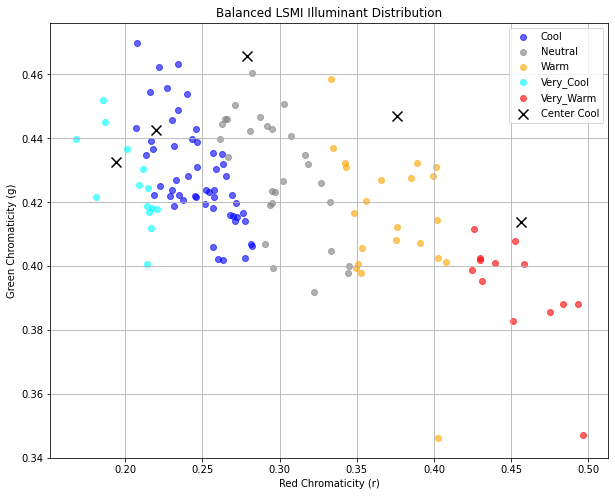

In [39]:
plt.figure(figsize=(10, 8))
colors = {'Cool': 'blue', 'Neutral': 'gray', 'Warm': 'orange', 'Very_Cool': 'cyan', 'Very_Warm': 'red'}

for cluster_name in cluster_names:
    subset = balanced_df[balanced_df['cluster_name'] == cluster_name]
    plt.scatter(subset['r'], subset['g'], label=cluster_name, color=colors.get(cluster_name, 'black'), alpha=0.6)

# Plot centers
for i, center in enumerate(center_points):
    plt.scatter(center[0], center[1], c='black', marker='x', s=100, label=f"Center {cluster_names[i]}" if i==0 else "")

plt.xlabel('Red Chromaticity (r)')
plt.ylabel('Green Chromaticity (g)')
plt.title('Balanced LSMI Illuminant Distribution')
plt.legend()
plt.grid(True)
plt.show()

### Scene Visualizations with Ground Truths
We visualize random scenes from the balanced dataset, overlaying the ground truth illuminant locations (MCC coordinates) and their cluster assignments.

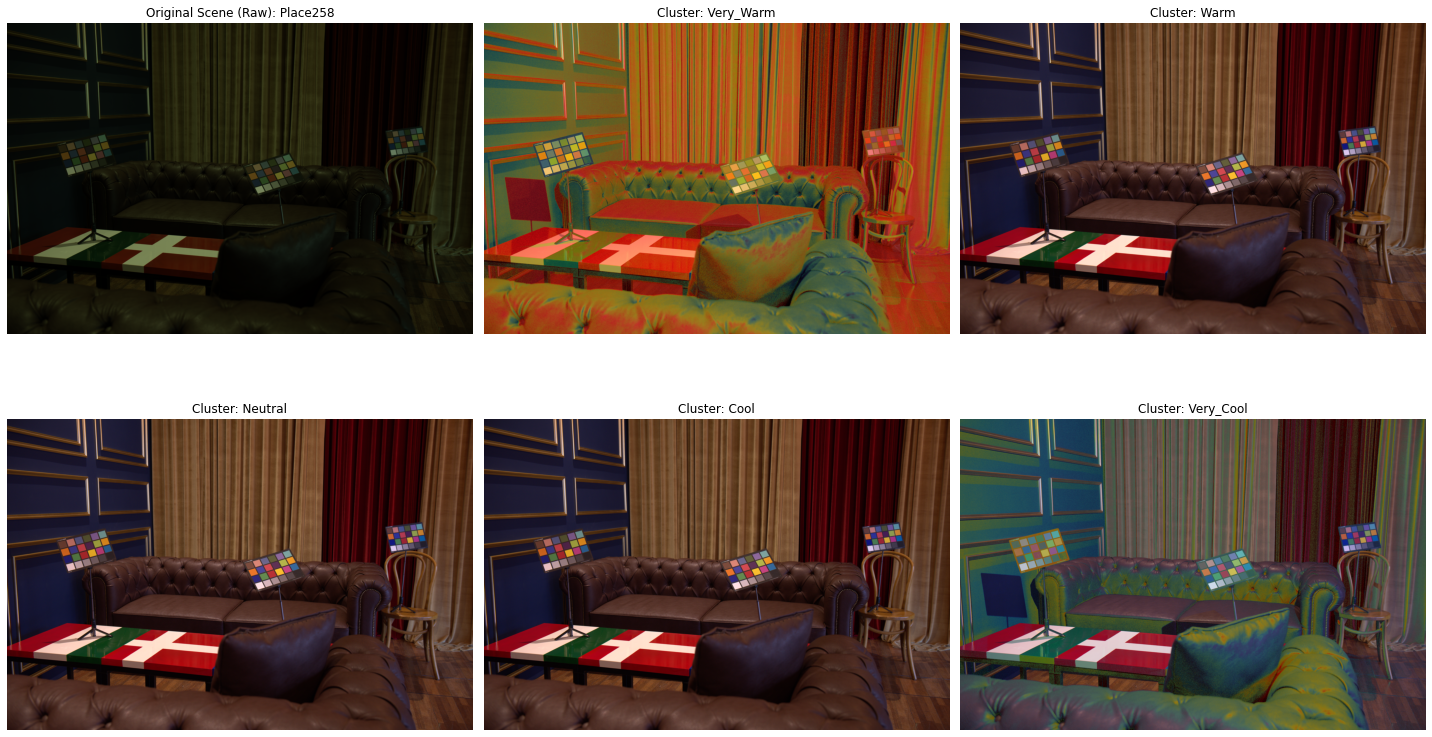

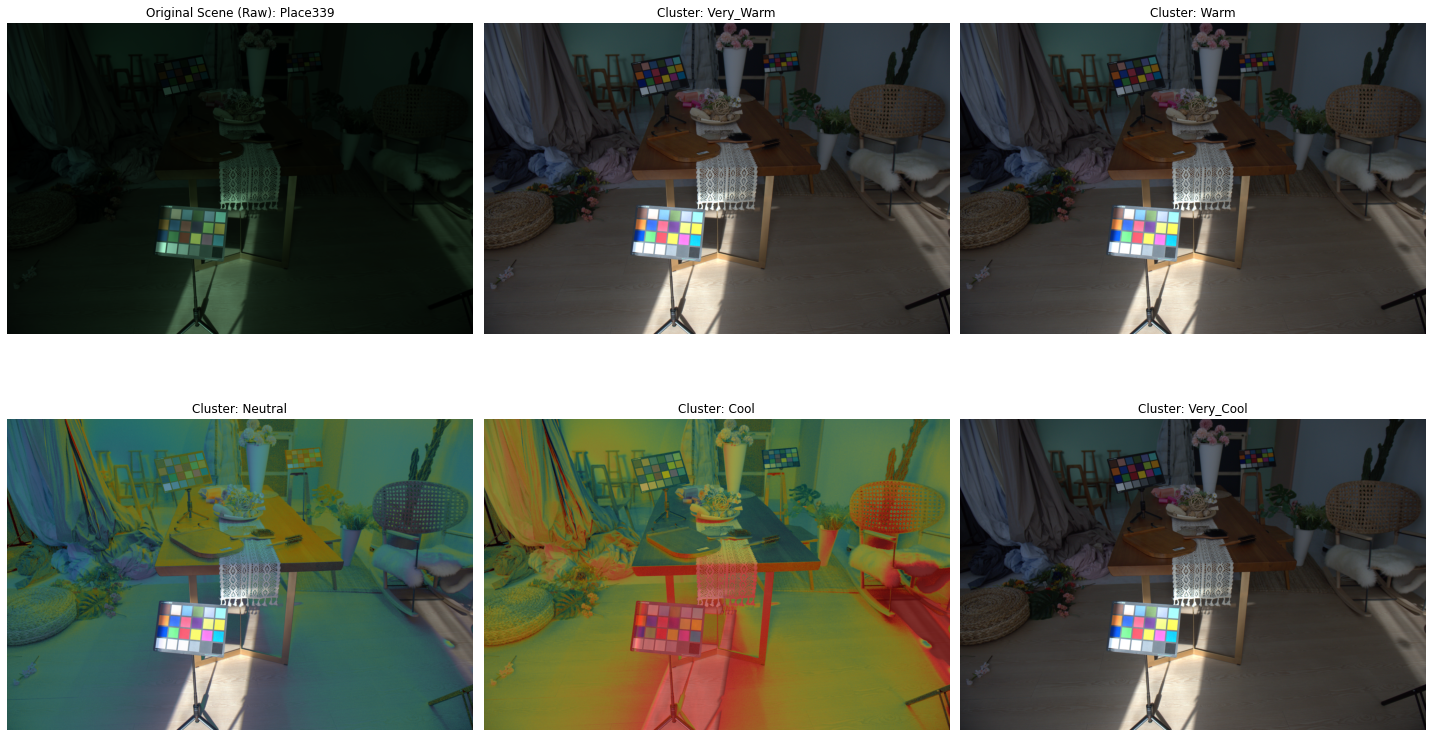

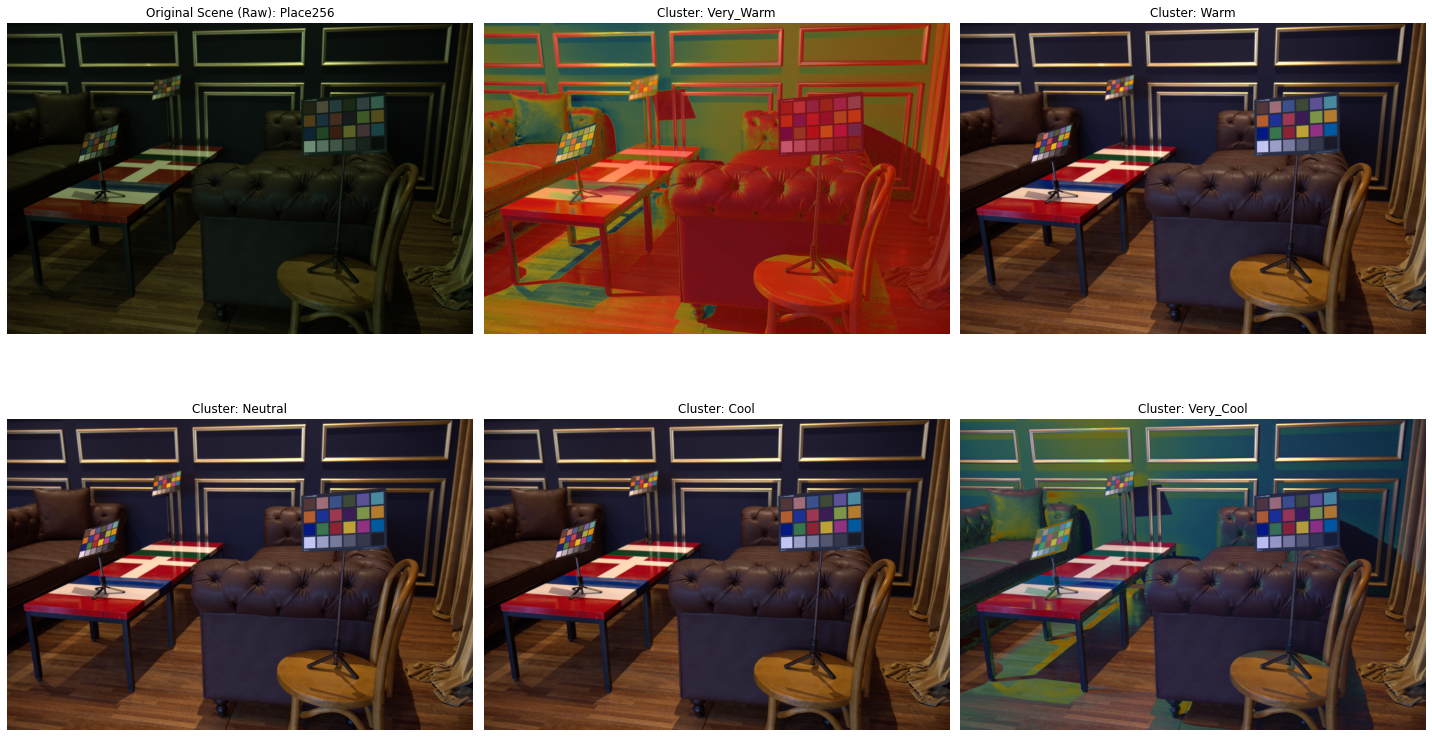

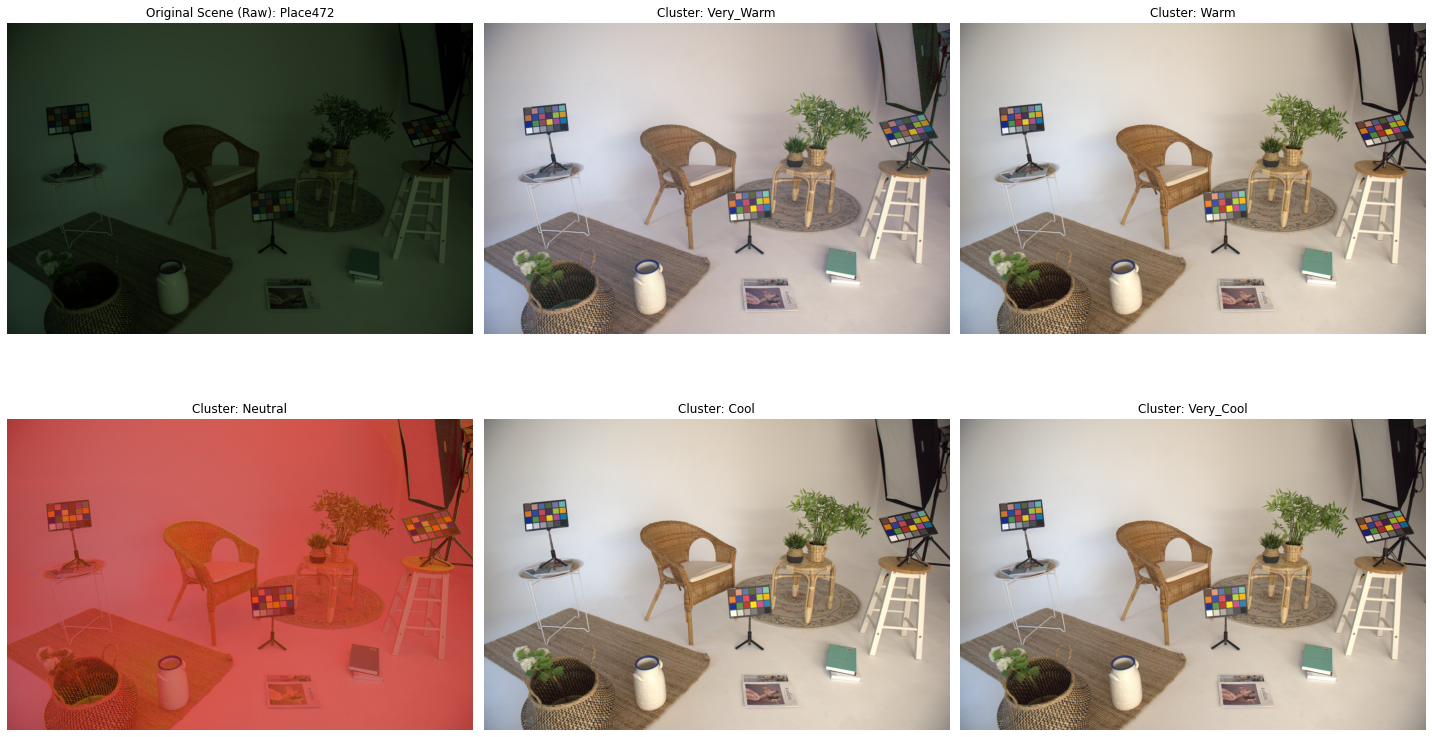

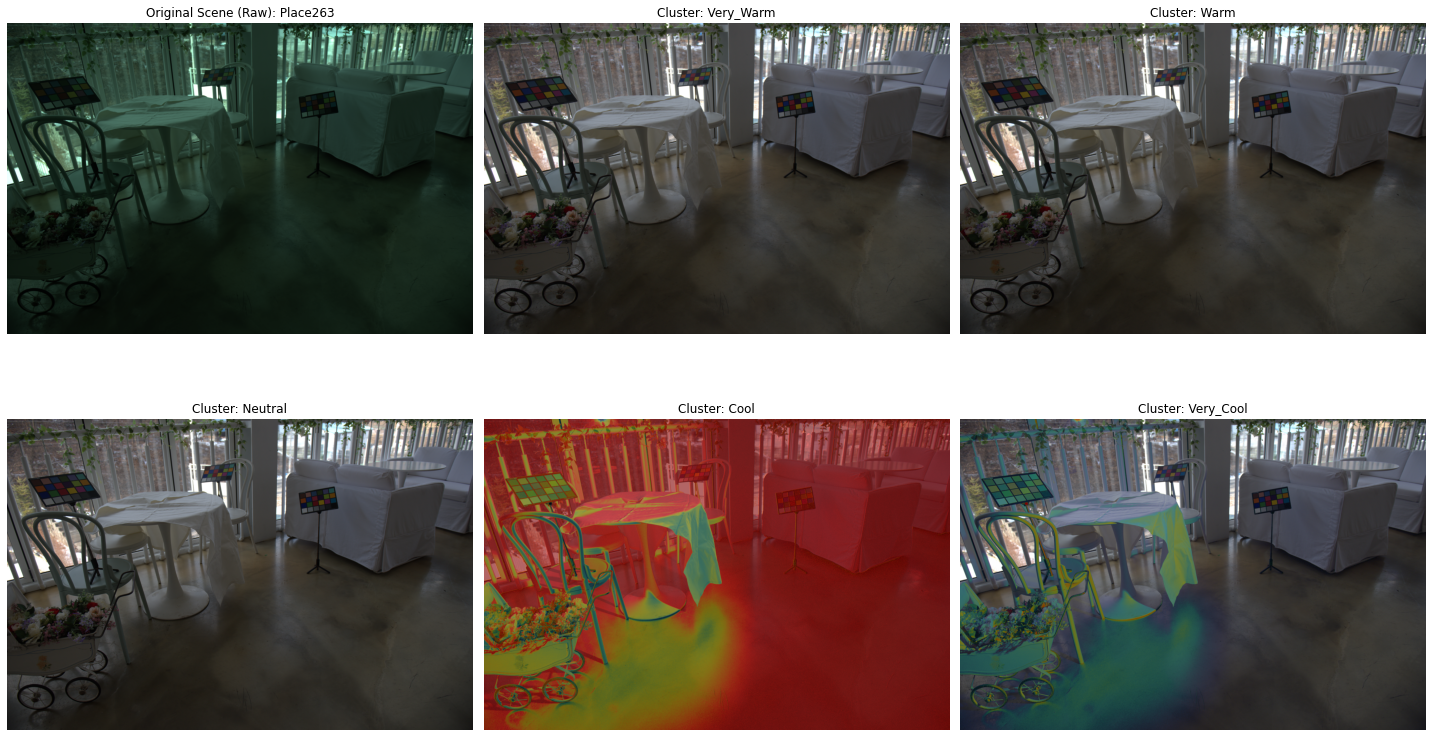

In [ ]:
def visualize_scene_with_masks(place_id, df_meta):
    meta = meta_data[place_id]
    raw_path = os.path.join(LSMI_ROOT, place_id, f"{place_id}_1.nef")
    mask_path = os.path.join("Data/LSMI_Masks", f"{place_id}_mask.npy")
    
    if not os.path.exists(raw_path):
        print(f"Image not found: {raw_path}")
        return
        
    if not os.path.exists(mask_path):
        print(f"Mask not found: {mask_path}")
        return

    # Process Image: Raw for Subplot 1
    img_raw = process_raw_image(raw_path, srgb=False)
    
    # Process Image: sRGB for Subplots 2-6 (Overlays)
    img_srgb = process_raw_image(raw_path, srgb=True)
    
    # Ensure img_srgb is uint8 for OpenCV operations
    if img_srgb.dtype != np.uint8:
        if img_srgb.max() <= 1.0:
            img_srgb = (img_srgb * 255).astype(np.uint8)
        else:
            img_srgb = img_srgb.astype(np.uint8)
    
    # Load Mask
    # Shape: (H, W, 5) -> Channels correspond to CLUSTER_NAMES
    mask = np.load(mask_path)
    
    # Defined in visualization_demo.ipynb
    CLUSTER_NAMES = ['Very_Warm', 'Warm', 'Neutral', 'Cool', 'Very_Cool']
    
    # Create 2x3 Plot
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    
    # Plot 1: Original Image (Raw)
    axes[0].imshow(img_raw)
    axes[0].set_title(f"Original Scene (Raw): {place_id}")
    axes[0].axis('off')
    
    max_alpha = 0.6
    
    # Plot 2-6: Cluster Overlays (on sRGB) using JET colormap
    for i, name in enumerate(CLUSTER_NAMES):
        ax = axes[i+1]
        
        # Get mask channel
        heatmap = mask[:, :, i]
        if heatmap.shape != img_srgb.shape[:2]:
            heatmap = cv2.resize(heatmap, (img_srgb.shape[1], img_srgb.shape[0]))
            
        # Normalize heatmap (0-1)
        heatmap_norm = np.clip(heatmap, 0, 1)
        
        # Apply Jet Colormap
        # cv2.applyColorMap expects uint8 input [0, 255]
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_norm), cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        
        # Alpha blending
        alpha_mask = heatmap_norm * max_alpha
        alpha_mask = np.expand_dims(alpha_mask, axis=-1)
        
        # Blend
        blended = (img_srgb * (1 - alpha_mask) + heatmap_colored * alpha_mask).astype(np.uint8)
        
        ax.imshow(blended)
        ax.set_title(f"Cluster: {name}")
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

# Visualize 5 random scenes from the balanced set
unique_places = balanced_df['place'].unique()
# Filter for places that have masks
places_with_masks = [p for p in unique_places if os.path.exists(os.path.join("Data/LSMI_Masks", f"{p}_mask.npy"))]
num_scenes = 5


if len(places_with_masks) > 0:
    sample_places = np.random.choice(places_with_masks, size=min(num_scenes, len(places_with_masks)), replace=False)
    for place in sample_places:
        visualize_scene_with_masks(place, balanced_df)
else:
    print("No masks found for the balanced scenes.")
